In [1]:
import matplotlib.pyplot as plt
import numpy as np
from optix import *

def custom_str_repr(gb: GaussianBeam) -> str:
    return f"""
    waist_loc\t=\t{gb.waist_location*10**2} cm
    waist_rad\t=\t{gb.waist_radius*10**3} mm
    ray_range\t=\t{gb.rayleigh_range*10**3} mm
    divergence\t=\t{gb.divergence*10**3} mrad
    """
GaussianBeam.__str__ = custom_str_repr

# Gaussovský svazek na výstupu z vlákna
Vlákno je označeno OE-000592. Bohužel na stránce TOPTICY žádné takové nanabízejí. Proto počítám se sepcifikami vláken https://www.toptica.com/products/optical-isolators-photonicals/photonicals/optical-fibers.

Pro získání Rayleigho vzdálenosti využit vzorec https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=14204


    waist_loc	=	0 cm
    waist_rad	=	0.00175 mm
    ray_range	=	0.02375587037436727 mm
    divergence	=	73.66600223110584 mrad
    


Text(0, 0.5, 'Beam diameter [mm]')

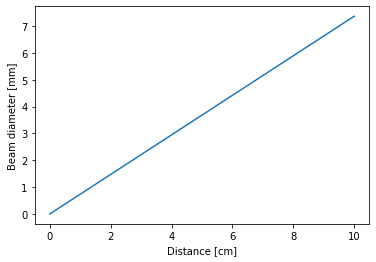

In [2]:
MFD = 3.5e-6
WAVE_LENGTH = 405e-9
w0 = MFD/2 
fiber_out = GaussianBeam(WAVE_LENGTH, w0=w0)
print(fiber_out)


z = np.linspace(0, 0.1, 100)
w = fiber_out.beam_radius(z)
plt.plot(z*10**2, w*10**3)
plt.xlabel("Distance [cm]")
plt.ylabel("Beam diameter [mm]")


# Šíření svazku krystalem
Předpoklad šíření podél osy $x$ přičemž čerpání je polarizováno horizontálně podél osy $y$. Posléze se generuje horizontální ($x$) a vertikální ($z$) fotony. Krystal od firmy Raicol má dimenze $1\times1\times2 mm$ a periodu pĺování $\Lambda = 10.025 \mu m$. Krystal KTP je dvojosý materiál s index lomu podél krystalografický os ($\lambda$ je v $\mu m$)
    $$ 
        n_x^2 = 3.29100 + \frac{0.04140}{\lambda^2 - 0.03978} + \frac{9.35522}{\lambda^2 - 31.45571} \\
        n_y^2 = 3.45018 + \frac{0.04341}{\lambda^2 - 0.04597} + \frac{16.98825}{\lambda^2 - 39.43799} \\
        n_z^2 = 4.59423 + \frac{0.06206}{\lambda^2 - 0.04763} + \frac{110.80672}{\lambda^2 - 86.12171}
    $$


Dle https://journals.aps.org/pra/abstract/10.1103/PhysRevA.81.053805 dochází k nejoptimálnější generaci SPDC při hodnotě kofokálního parametru $\xi_s \approx \xi_i \approx \xi_p \approx 2.84$. Přičemž platí, že 
    $$\xi_j = \frac{L}{k_j w_j^2},$$
kde $L$ je délka krystalu, $k_j$ je odpovídající vlnové číslo a $w_j$ je velikost krčku Gaussovského svazku. Tedy podmínka na velikost krčku je 
    $$w_j = \sqrt{\frac{L}{k_j \xi_j}} \approx \sqrt{\frac{L}{2.84 \cdot k_j }}, \quad k_j = \frac{\omega_j}{c} \cdot n_j(\omega_j).$$


In [3]:
LIGHT_SPEED = 299_792_458
def KTP_n_x(wl) -> float:
    return math.sqrt(3.29100 + 0.04140 / (wl**2 - 0.03978) + 9.35522 / (wl**2 - 31.45571))

def KTP_n_y(wl) -> float:
    return math.sqrt(3.45018 + 0.04341 / (wl**2 - 0.04597) + 16.98825 / (wl**2 - 39.43799))

def KTP_n_z(wl) -> float:
    return math.sqrt(4.59423 + 0.06206 / (wl**2 - 0.04763) + 110.80672 / (wl**2 - 86.12171))

def to_freq(wl) -> float:
    """Converts wavelength to angular frequency"""
    return 2 * math.pi * LIGHT_SPEED / wl

def to_wavelength(freq) -> float:
    """Converts angular frequency to wavelength"""
    return 2 * math.pi * LIGHT_SPEED / freq

In [4]:
CRYSTAL_LENGTH = 2e-2 # 2cm krystal od Raicolu
FOCAL_PARAM = 2.84 #optimum 2.84

n_p = KTP_n_y(WAVE_LENGTH*10**(-3)) # Pump je horizontálne polarizovaný, vkládám v mikrometrech
n_s = KTP_n_y(WAVE_LENGTH*10**(-3)*2)
n_i = KTP_n_z(WAVE_LENGTH*10**(-3)*2)

omega_p = to_freq(WAVE_LENGTH)
omega_s = to_freq(WAVE_LENGTH * 2)
omega_i = to_freq(WAVE_LENGTH * 2)

# Vlnové číslo příslušné polarizace již v KTP krystalu
k_p = omega_p / LIGHT_SPEED * n_p  
k_s = omega_s / LIGHT_SPEED * n_s
k_i = omega_i / LIGHT_SPEED * n_i

# Optimální šířka krčku v krystalu příslušného svazku
w_p = math.sqrt(CRYSTAL_LENGTH / (FOCAL_PARAM * k_p))
w_s = math.sqrt(CRYSTAL_LENGTH / (FOCAL_PARAM * k_s))
w_i = math.sqrt(CRYSTAL_LENGTH / (FOCAL_PARAM * k_i))

focus_info = f"""
    n_p = {n_p}, omega_p = {omega_p}s^-1, k_p = {k_p}m^-1, w_p = {w_p*10**6} um
    n_s = {n_s}, omega_s = {omega_s}s^-1, k_s = {k_s}m^-1, w_s = {w_s*10**6} um
    n_i = {n_i}, omega_i = {omega_i}s^-1, k_i = {k_i}m^-1, w_i = {w_i*10**6} um
"""
print(f"Optimal focus in crystal of length {CRYSTAL_LENGTH*10**3}mm:")
print(focus_info)

Optimal focus in crystal of length 20.0mm:

    n_p = 1.4405242023903018, omega_p = 4650991524219391.0s^-1, k_p = 22348346.921223056m^-1, w_p = 17.751421063770742 um
    n_s = 1.4405242023903018, omega_s = 2325495762109695.5s^-1, k_s = 11174173.460611528m^-1, w_s = 25.104300419780017 um
    n_i = 1.4158532155790764, omega_i = 2325495762109695.5s^-1, k_i = 10982800.149690649m^-1, w_i = 25.322074799497845 um



In [29]:
# Nastavuji aby se při printování Gausovského svazku defaultně zobrazila i informace o parametru xi
def custom_str_repr_xi(gb: GaussianBeam) -> str:
    return f"""
    waist_loc   =\t{gb.waist_location*10**2} cm
    waist_rad   =\t{gb.waist_radius*10**3} mm
    ray_range   =\t{gb.rayleigh_range*10**3} mm
    divergence  =\t{gb.divergence*10**3} mrad
    xi          =\t{CRYSTAL_LENGTH / (gb.waist_radius**2 * k_p) }
    """

GaussianBeam.__str__ = custom_str_repr_xi


# Propagace systémem

In [5]:
from __future__ import annotations
N_BK7 = 1.5302 # Na 405nm

class TheLayout(OpticalPath):
    d_c: float # Poloha kolimační čočky (zafixuji aby odpovídala ohnisku)
    f_c: float # Ohnisková vzdálenost kolimační čočky
    d_f: float # Poloha fokusační čočky
    f_f: float # Ohnisko fokusační čočky
    d_cr: float # Poloha středu krystalu

    COLIMATION_LENSES = {
    25e-3: PlanoConvexLens(R=13.1e-3, n=N_BK7, d=11.7e-3),             # <--- Thorlabs LA1951-A, 25mm
    35e-3: PlanoConvexLens(R=18e-3, n=N_BK7, d=7e-3),                  # <--- Thorlabs LA1027-A, 35mm
    50e-3: PlanoConvexLens(R=25.8e-3, n=N_BK7, d=5.3e-3)               # <--- ThorLabs LA1131-A, 50mm
    }

    FOCUSING_LENSES = [100e-3, 125e-3, 150e-3, 200e-3, 250e-3, 300e-3, 400e-3]


    def build(self):
        self.clear()
        self.build_colimation_stage()
        self.build_focusing_stage()
        self.build_crystal_propagation()

    def clear(self):
        self._elements = []

    def build_colimation_stage(self) -> None:
        self.append(FreeSpace(self.d_c))
        self.append(self.COLIMATION_LENSES[self.f_c])                                        

    def build_focusing_stage(self) -> None:
        self.append(FreeSpace(self.d_f))
        self.append(ThinLens(self.f_f))                                   

    def build_crystal_propagation(self) -> None:
        self.append(FreeSpace(self.d_cr - CRYSTAL_LENGTH/2))              
        self.append(FlatInterface(1, n_p))
        self.append(FreeSpace(CRYSTAL_LENGTH/2))

    def clone(self) -> TheLayout:
        l = TheLayout()
        l.d_c = self.d_c
        l.f_c = self.f_c
        l.d_f = self.d_f
        l.f_f = self.f_f
        l.d_cr = self.d_cr
        return l

    def __str__(self) -> str:
        return f"""
            d_col       =   {self.d_c*10**3}mm,
            f_col       =   {self.f_c*10**3}mm,
            d_focus     =   {self.d_f*10**3}mm,
            f_focus     =   {self.f_f*10**3}mm,
            d_crystal   =  {self.d_cr*10**3}mm
        """




In [23]:
class Drawer:
    __UNITS = {
        "um": 10**6,
        "mm": 10**3,
        "cm": 10**2,
        "dm": 10**1,
        "m":  10**0
    }

    def __init__(self, op: OpticalPath, gauss_in: GaussianBeam, **kwargs) -> None:
        self.op_origin = op
        self.z_unit = kwargs.get("z_unit", "mm")
        self.w_unit = kwargs.get("w_unit", "mm")
        self.color = kwargs.get("color", "blue")
        self.draw_childs = kwargs.get("draw_childs", True)
        self.__op_temp = OpticalPath()
        self.gauss_in = gauss_in
        self.__fig, self.ax = plt.subplots()
        self.current_z = 0


    def show(self):
        self.draw().show()

    def draw(self):
        for i, element in enumerate(self.op_origin.childs):
            self.draw_element(element)
            self.ax.axvline(self.__z_unit_transform(self.current_z) , linewidth=1, color="black")
            # self.ax.annotate(f" {i+1}.", (self.__z_unit_transform(self.current_z), 0))

            self.ax.set_xlabel(f"Distance [{self.z_unit}]")
            self.ax.set_ylabel(f"W [{self.w_unit}]")
        # self.ax.legend(self.__build_legend(),handletextpad=-2.0, handlelength=0)
        return self.__fig      

    def draw_element(s, element):
        if isinstance(element, ABCDCompositeElement):
            if s.draw_childs:   
                for child in element.childs:
                    s.draw_element(child)
            else:
                s.__op_temp.append(element)
        elif isinstance(element, ABCDElement):
            s.__op_temp.append(element)
            if element.length > 0:
                gauss_temp = s.__op_temp.propagate(s.gauss_in)
                z = np.linspace(s.current_z, s.current_z + element.length, 100)
                w = gauss_temp.beam_radius(z)
                s.ax.plot(s.__z_unit_transform(z), s.__w_unit_transform(w), label=element.name, color=s.color)
                s.current_z += element.length

    def __z_unit_transform(self, z):
        return z * self.__UNITS[self.z_unit]

    def __w_unit_transform(self, w):
        return w * self.__UNITS[self.w_unit]
            
    def __build_legend(self):
        labels = [f"{i+1}. {c.name}" for i, c in enumerate(self.op_origin.childs)]
        return labels



    waist_loc   =	40.35375276644498 cm
    waist_rad   =	0.011544034210967278 mm
    ray_range   =	1.033736996930732 mm
    divergence  =	11.16728359848072 mrad
    xi          =	6.7153612599475805
    


C:\Users\david\AppData\Local\Temp\ipykernel_24144\4079340933.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.draw().show()


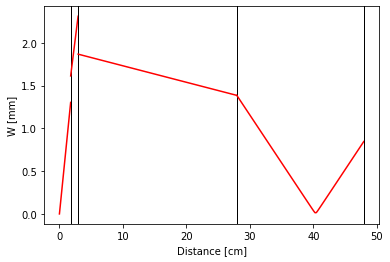

In [30]:
gauss_in = fiber_out
layout = TheLayout()
layout.f_c = 2.5e-2
layout.d_c = TheLayout.COLIMATION_LENSES[layout.f_c].f - 7e-3
layout.d_f = 250e-3
layout.f_f = 150e-3

layout.build_colimation_stage()
layout.build_focusing_stage()
layout.append(FreeSpace(0.2))

gauss_out = layout.propagate(gauss_in)
print(gauss_out)
Drawer(layout, gauss_in, z_unit="cm", w_unit="mm", color="red").show()

